# CMB Temperature Map Simulations

## Importing Necessary Modules

This code creates unlensed Q & U maps of the CMB and phi map FFTs which can be used to lens them using QuickLens.

It takes in a CMB spectrum generated by CAMB (https://camb.info/readme.html).

#### Order matters here. The code breaks if you import pymaster after numpy or matplotlib.

In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline

In [2]:
import flatmaps as fm
from astropy.wcs import WCS
from scipy.interpolate import interp1d

## Defining Map Parameters

In [3]:
# Create the empty map object with the resolution that we want
# Set parameters for empy map with resolution

pixels = 192. #192 pixels on each degrees
degrees = 5 #5 degrees on each degrees

reso = degrees/pixels 
reso_arcmin = reso*60
dx = reso*np.pi/180.0 #Resolution in radians

lmax = 180./reso #Maximum l-mode achievable given these parameters
lstep = lmax*2/pixels

tfac = dx/pixels #converts from pixels to radians

In [4]:
#Generate the WCS (world coordinate system) for the flatmap
#FIXME: coordinates function
w = WCS(naxis=2)
nx = int(pixels)
ny = int(pixels) 

w.wcs.crpix = [nx/2, ny/2] #Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] #Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] #Airy projection; can be adjusted. Previous used Azimuthal equal-area

In [5]:
# This is the map object that will be used to generate the fake CMB maps
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=degrees, ly=degrees) 

## Setting plotting settings

In [6]:
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

## Defining functions

In [7]:
#Function to concatenate [0,0] to spectrum to account for zeroed-out l-mode for 0 and 1 modes
#The simulation code, synfast_flat, interprets the first two numbers as the 0- and 1-mode.
#Since our spectrum starts at the second mode, I set the amplitude for the 0-mode and 1-mode to 0.
def add_zeroed_modes(spectrum, l_array=False):
    if l_array==False:
        concatenated_spectrum = np.concatenate(([0,0],spectrum))
    else:
        concatenated_spectrum = np.concatenate(([0,1],spectrum))
    return concatenated_spectrum

In [8]:
#Function for loading in CMB spectrum, returns dictionary containing l-modes and spectra
def load_cmb_spectra(location, fix_scaling=True, add_zeroed=True):
    #Loading in pregenerated spectra using CAMB
    #Spectra are respectively:
    #Temperature-Temperature, E mode-E mode, Temperature-E mode cross spectrum, Phi-Phi, Phi-Temperature cross
    l_modes, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)
    
    #CAMB scales spectra, so we fix that before feeding it into the map generation code
    if fix_scaling:
        clTTb = clTTa /((l_modes*(l_modes+1)/(2*np.pi)))
        clEEb = clEEa /((l_modes*(l_modes+1)/(2*np.pi)))
        clTEb = clTEa /((l_modes*(l_modes+1)/(2*np.pi)))
        clPPb = clPPa / (l_modes**4 * (2.726 * 1e6)**2)
        clPTb = clPTa / (l_modes**4 * (2.726 * 1e6)**2)
    
    #The 
    if add_zeroed:
        l_modes = add_zeroed_modes(l_modes, l_array=True)
        clTT = add_zeroed_modes(clTTb)
        clEE = add_zeroed_modes(clEEb)
        clTE = add_zeroed_modes(clTEb)
        clPP = add_zeroed_modes(clPPb)
        clPT = add_zeroed_modes(clPTb)
        cmb_spectra = {"l modes":l_modes, "clTT":clTT, "clTE":clTE, "clEE":clEE, "clPP":clPP, "clPT":clPT}
        
    elif fix_scaling:
        cmb_spectra = {"l modes":l_modes, "clTT":clTTb, "clTE":clTEb, "clEE":clEEb, "clPP":clPPb, "clPT":clPTb}
        
    else:
        cmb_spectra = {"l modes":l_modes, "clTT":clTTa, "cleTE":clTEa, "clEE":clEEa, "clPP":clPPa, "clPT":clPTa}
    return cmb_spectra
    

In [9]:
#Function for plotting spectrum
def spectrum_plot(l_modes, spectrum, title):
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.plot(l_modes, spectrum, label=title)
    plt.xscale("log")
    plt.yscale("log")
    plt.tick_params(labelsize=15)
    plt.xlabel("$\mathit{l}$", fontsize=30)
    plt.ylabel("$\lambda K$", fontsize=30)
    plt.title("TT Spectrum", fontsize=24)
    ax.legend(bbox_to_anchor=(1.55, 1.0))
    
    return fig

In [10]:
def frequency_domain_plot(input_map_fft, title, scaling, colorbar_label):
    fig = plt.figure()
    plt.imshow(np.log10(np.abs(input_map_fft)), vmin=scaling[0], vmax=scaling[1])
    plt.colorbar(label=colorbar_label)
    plt.title(title)
    
    return fig

In [11]:
#Function for plotting 2D FFT
def calculate_and_plot_fft(input_map, title, real=False, scaling=[0,6], colorbar_label="Log of Map Strength"):
    #This needs to be an rfft for the actual analysis and a complex fft for estimating spectra
    if real:
        input_map_fft = np.fft.rfft2(input_map)
    else:
        input_map_fft = np.fft.fft2(input_map)

    fig = frequency_domain_plot(input_map_fft, title, scaling, colorbar_label)

    #np.save("phi_map_fft_0-mode", phi_map_fft)
    return fig

In [12]:
#Function for making 2D Power Map
def calculate_map_power_2D(input_map, real=False):
    #FFT needs to be real for the analysis and complex estimating spectra
    if real:
        input_map_fft = np.fft.rfft2(input_map)
    else:
        input_map_fft = np.fft.fft2(input_map)
    
    #Taking the conjugate of the phi map fft
    input_map_fft_conj = np.conj(input_map_fft)
    
    #Calculating the 2D Map Power
    map_power_2D = input_map_fft*input_map_fft_conj*tfac**2
    
    return map_power_2D

In [13]:
def calculate_power_spectrum(input_map, bin_num=80, pixels=192):
    map_power_2D = calculate_map_power_2D(input_map, real=False)

    #Dividing data into four quarters, rotating so lowest mode is in top left quarter
    quarter1 = map_power_2D[:int(pixels/2),:int(pixels/2)]

    quarter2 = map_power_2D[:int(pixels/2),int(pixels/2+1):]
    quarter2 = np.rot90(quarter2)

    quarter3 = map_power_2D[int(pixels/2+1):,:int(pixels/2)]
    quarter3 = np.rot90(quarter3, k=3)

    quarter4 = map_power_2D[int(pixels/2+1):,int(pixels/2+1):]
    quarter4 = np.rot90(quarter4, k=2)

    #Highest l-mode achievable, 192 pixels, divided into 4 quarters, with lstep = 72
    peak_l = pixels/2*72

    #Creating empty arrays:
    spectra_est = np.zeros((bin_num)) #spectum sum before averaging
    spectra_est_avg_bins = np.zeros((bin_num)) #spectrum estimate after averaging
    n = np.zeros((bin_num))#number of points going into each bin/annulus

    #Defining edges of bins
    bin_edges = np.linspace(0,np.sqrt(2)*peak_l, bin_num+1)
    
    #Defining width of 1 bin
    bin_step = bin_edges[1]

    #Calculating bin centers
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    #Creating array containing each quarter of data
    quarter_list = [quarter1, quarter2, quarter3, quarter4]

    #Looping over each quarter
    for quarter in quarter_list:
    
        #Looping over row
        for i, spec in enumerate(quarter):
            lx_ = 72.*i #the l-mode in the x-direction
    
            #Looping over each pixel in each row
            for j, pwr in enumerate(quarter):
            
                ly_ = 72.*j #the l-mode in the y-direction
            
                #Calculate overall l-mode for each pixel
                point_on_circ = np.sqrt(lx_**2+ly_**2) #overall l-mode

                #Determine which been l-mode belongs to by seeing which is the largest lefthand edge smaller than pixel's overall l-mode
                left_bin_edge = np.where(bin_edges <= point_on_circ)[0][-1] #largest bin that's smaller than overall l-mode
            
                #Add power from that pixel to spectrum estimate
                spectra_est[left_bin_edge] += map_power_2D[i,j] #adding power at coordinate (i,j) to bin
            
                #Tally the pixel as being in this particular been (for averaging later)
                n[left_bin_edge] += 1 #counting the number of points in the bin for averaging later
                
    #Divide the spectrum by the number of pixels that went into each bin
    spectra_est_avg_bins = spectra_est / n
    
    return bin_centers, spectra_est_avg_bins

In [24]:
def plot_spectra(l_modes, spectra, plot_title, plot_labels):
    #Approximate spectrum
    #Lowest mode is determined by smallest l measurable (determined by bin width (determined by # of bins))
    fig = plt.figure()
    if (type(l_modes) == list) and len(l_modes)>1:
        for i, spectrum in enumerate(spectra):
            plt.plot(l_modes[i],spectra[i],label=plot_labels[i])
            
    elif type(l_modes == np.ndarray) and len(np.shape(l_modes))>1:
        for i, spectrum in enumerate(spectra):
            plt.plot(l_modes[i],spectra[i],label=plot_labels[i])
            
    else:
        plt.plot(l_modes,spectra,label=plot_labels)
    
    plt.legend(loc="lower left")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(plot_title)
    plt.xlabel("$l$ mode")
    plt.ylabel("$C_{l}$")
    return fig

In [82]:
def generate_maps(spectra_dict, fmi, num_maps, temp_only=False, TQU_maps=False, TEB_maps=False, start_seed = 0):
    if start_seed != 0:
        set_seed = True
    
    if ((TQU_maps and TEB_maps) or (TQU_maps and temp_only)) or (TEB_maps and temp_only):
        print("You can only pick temperature-map only, TQU maps, or TEB maps.")
        return None
        
    elif temp_only:
        i=0
        all_maps = np.zeros([num_maps,1,int(pixels),int(pixels)])
        while i < num_maps:
            if set_seed = True:
                one_map_set = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad,np.array([spectra_dict["clTT"], spectra_dict["clTE"], spectra_dict["clTB"], spectra_dict["clEE"], spectra_dict["clEB"], spectra_dict["clBB"]]),[0,0,0],start_seed)
            else:
                one_map_set = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad,np.array([spectra_dict["clTT"], spectra_dict["clTE"], spectra_dict["clTB"], spectra_dict["clEE"], spectra_dict["clEB"], spectra_dict["clBB"]]),[0,0,0],i)
                
            all_maps[i] = one_map_set
            
            if np.mod(i,100) == 0:
                print(i,)
            i+=1
            
    elif TQU_maps:
        all_maps = np.zeros([num_maps,3,int(pixels),int(pixels)])
        while i < num_maps:
            one_map_set = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad,np.array([spectra_dict["clTT"], spectra_dict["clTE"], spectra_dict["clTB"], spectra_dict["clEE"], spectra_dict["clEB"], spectra_dict["clBB"]]),[0,2])
            all_maps[i] = one_map_set
            
            if np.mod(i,100) == 0:
                print(i,)
            i+=1

    elif TEB_maps:
        all_maps = np.zeros([num_maps,3,int(pixels),int(pixels)])
        while i < num_maps:
            one_map_set = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad,np.array([spectra_dict["clTT"], spectra_dict["clTE"], spectra_dict["clTB"], spectra_dict["clEE"], spectra_dict["clEB"], spectra_dict["clBB"]]),[0,0,0])
            all_maps[i] = one_map_set
            
            if np.mod(i,100) == 0:
                print(i,)
            i+=1
        
        
    else:
        print("What type of maps did you want?")
        return None
    
    return maps

SyntaxError: invalid syntax (<ipython-input-82-7c43066399c4>, line 13)

## Importing spectrum generated by CAMB

In [61]:
spectra_dict = load_cmb_spectra("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", fix_scaling=True, add_zeroed=True)

spectra_dict["clTB"] = 0 * spectra_dict["clTT"]
spectra_dict["clBB"] = 0 * spectra_dict["clTT"]
spectra_dict["clEB"] = 0 * spectra_dict["clTT"]

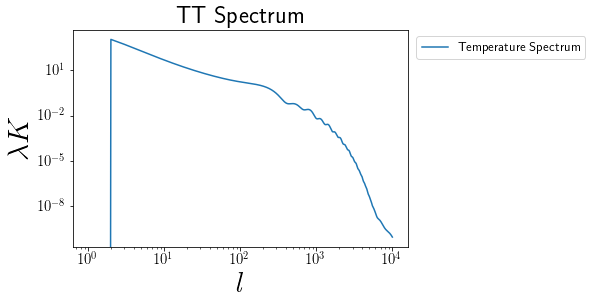

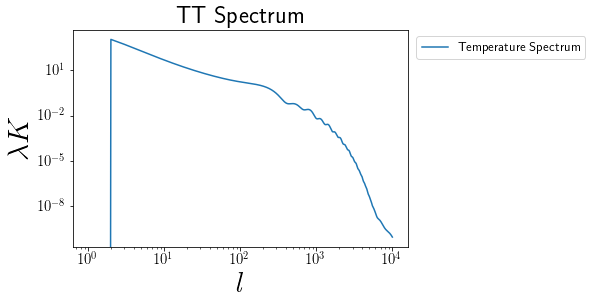

In [16]:
spectrum_plot(spectra_dict["l modes"], spectra_dict["clTT"], "Temperature Spectrum")

## Generating Simulations

The specific function used is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/master/src/nmt_field_flat.c#L431

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate # of maps to be calculated for each spin and each spectrum (and # of spectra associated)

-Calculate ALMs using fs_synalm:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

-Loop through the ALMs to and convert from the spectra to the map using fs_alm2map:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L220

-Return the maps

The ALMs function is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate maximum achievable l-mode (lmax), set to inv_dkvol (I think, inv_dkvol has the same calculation as my lmax)

-Looping over each pixel and calculating the associated mode in x-, y- directions and their geometric average (overall mode)

-Calculate the associated amplitude given the input spectrum (spectrum is splined, then overall mode fed to spline)

-Calculate "true" spectrum value as 1/2*lmax*input spectrum amplitude (But why is this the value?)

-Generate randomn numbers using rng_gauss, incorporate it using gsl_matrix_set

-Calculate the beam pattern by splining and evaluating inputted beam

-Multiplies the beam pattern against vector containing random numbers, sets this to real and imaginary parts of A

-Setting Alms to these values for different frequency values

-Returns Alms

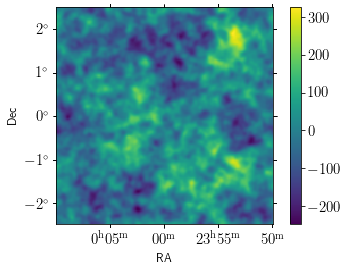

In [17]:
#Function that generates the simulation
temperature_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [spectra_dict["clTT"]],[0], seed = 100)
#The inputs are: pixels in x- and y-directions, length of side in radians, spectra, spin of simulated map, random seed

#Demo of randomly generated map
fmi.view_map(temperature_map[0].flatten()) 

## Calculating the Spectrum

### Calculating FFT & Power Spectrum

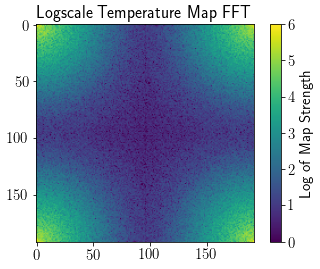

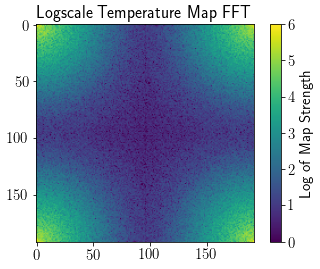

In [18]:
calculate_and_plot_fft(temperature_map[0], "Logscale Temperature Map FFT")

In [19]:
#Calculating the 2D Map Power
map_power_2D = calculate_map_power_2D(temperature_map[0])

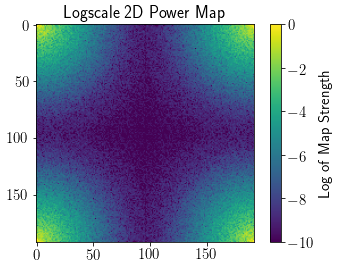

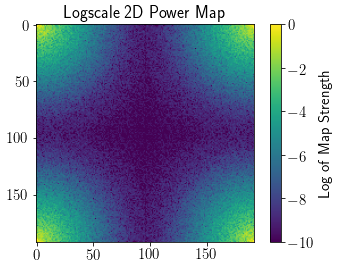

In [20]:
#Plot 2D Map Power
frequency_domain_plot(map_power_2D,"Logscale 2D Power Map", [-10,0], "Log of Map Strength")

### Summing over each annulus for all four quarters

In [21]:
spectrum = calculate_power_spectrum(temperature_map[0])

<ipython-input-13-0ba85182a2d1>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  spectra_est[left_bin_edge] += map_power_2D[i,j] #adding power at coordinate (i,j) to bin


<ipython-input-24-66a51a14d4a9>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif type(l_modes == np.ndarray) and len(np.shape(l_modes))>1:


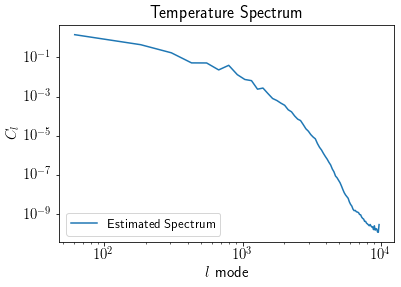

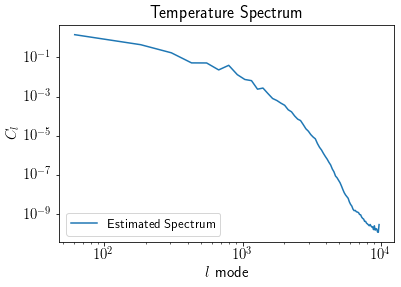

In [25]:
#Approximate spectrum
#Lowest mode is determined by smallest l measurable (determined by bin width (determined by # of bins))
plot_spectra(spectrum[0],spectrum[1], "Temperature Spectrum", "Estimated Spectrum")

### Plotting estimated spectrum, Comparing to input spectrum

In [27]:
#Spline data to compare input spectrum to estimated spectrum
f1 = interp1d(spectra_dict["l modes"], spectra_dict["clTT"], kind="nearest")
f2 = interp1d(spectrum[0], spectrum[1], kind="nearest")

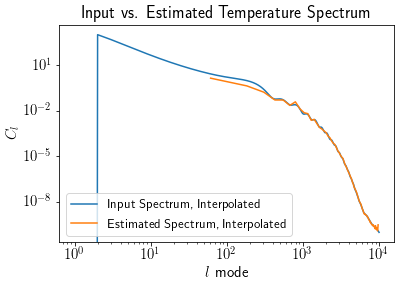

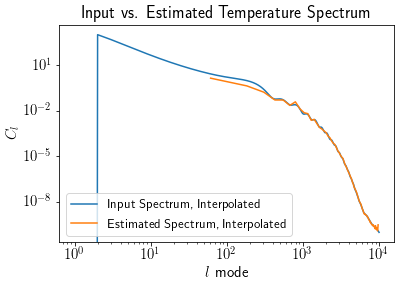

In [29]:
l_mode_list = [spectra_dict["l modes"], spectrum[0]]
spectra = [f1(spectra_dict["l modes"]), f2(spectrum[0])]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated"]
plot_spectra(l_mode_list, spectra, "Input vs. Estimated Temperature Spectrum", labels)

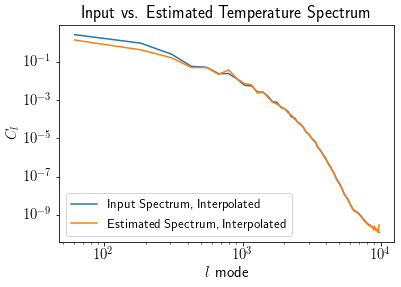

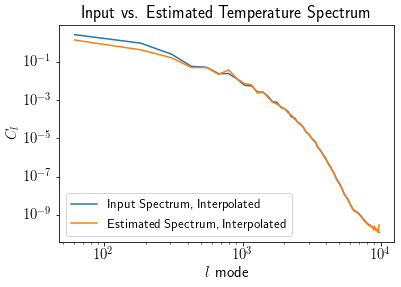

In [31]:
#Zooming in on above plot to domain which both spectra are valid
l_mode_list = [spectrum[0], spectrum[0]]
spectra = [f1(spectrum[0]), f2(spectrum[0])]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated"]
plot_spectra(l_mode_list, spectra, "Input vs. Estimated Temperature Spectrum", labels)

## Testing Spectrum Estimate Against Joao's Method

##### Joao's method of spectrum estimation histograms each pixel then weights its contribution 

In [32]:
#Defining bin sizes
binsize = np.sqrt(2)*np.pi/(dx*pixels)
lbins = np.arange(binsize, lmax, binsize)
cbins = 0.5*(lbins[0:-1] + lbins[1:])

In [33]:
#Create grid to define l-mode in x- and y-directions and overall l as their geometric sum
lx, ly = np.meshgrid(np.linspace(-lmax+lstep, lmax, int(pixels)),np.linspace(-lmax+lstep, lmax, int(pixels)))
ell = np.sqrt(lx**2 + ly**2)

In [36]:
#Histogramming l-modes into bins for normalization later 
norm, bins = np.histogram(ell, bins=spectrum[0])
norm = norm.astype(float)
norm[ np.where(norm != 0.0) ] = 1./norm[ np.where(norm != 0.0) ]

In [37]:
#Create 2D power map
temperature_map_real_fft = np.fft.fft2(temperature_map[0])
temperature_map_real_fft_conj = np.conj(temperature_map_real_fft)
real_map_power_2D = temperature_map_real_fft*temperature_map_real_fft_conj
#"spectrum_2D" is the same as the powermap but recentered so the 0-mode is in the middle
spectrum_2D = np.fft.fftshift(real_map_power_2D*tfac**2)

In [39]:
#Histogramming l-modes from above, weighting by the 2D powerspectrum
joao_spectrum, bins = np.histogram(ell, bins=spectrum[0],weights=spectrum_2D)

#Normalizing to account for different number of l-modes in eac bin
joao_spectrum *= norm

<ipython-input-24-66a51a14d4a9>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif type(l_modes == np.ndarray) and len(np.shape(l_modes))>1:
/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


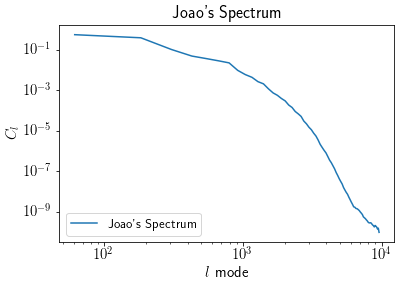

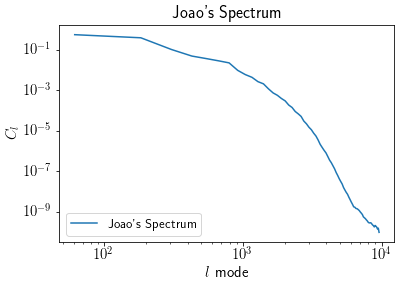

In [48]:
#Plot the spectrum
plot_spectra(spectrum[0][:-1], joao_spectrum,"Joao's Spectrum", "Joao's Spectrum")

/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


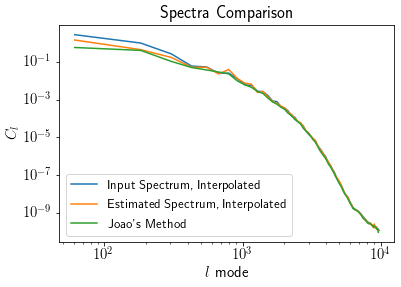

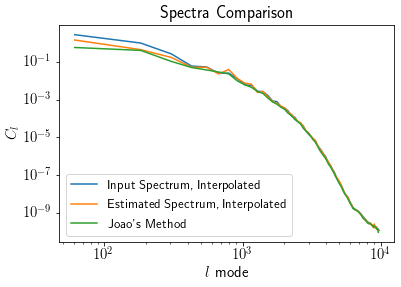

In [52]:
#Compare with the input spectrum and my estimated spectrum splined earlier
l_mode_list = [spectrum[0], spectrum[0][:-1], spectrum[0][:-1]]
spectra = [f1(spectrum[0]), f2(spectrum[0][:-1]),joao_spectrum]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated", "Joao's Method"]
plot_spectra(l_mode_list, spectra,"Spectra Comparison", labels)

/Users/samanthausman/anaconda2/envs/simcmb/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


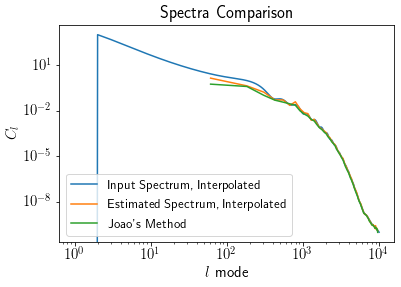

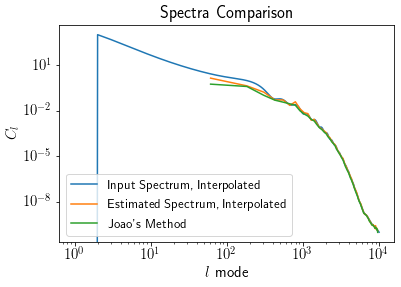

In [53]:
#Compare with the input spectrum and my estimated spectrum splined earlier
l_mode_list = [spectra_dict["l modes"], spectrum[0][:-1], spectrum[0][:-1]]
spectra = [f1(spectra_dict["l modes"]), f2(spectrum[0][:-1]),joao_spectrum]
labels = ["Input Spectrum, Interpolated","Estimated Spectrum, Interpolated", "Joao's Method"]
plot_spectra(l_mode_list, spectra,"Spectra Comparison", labels)

In [81]:
maps = generate_maps(spectra_dict, fmi, 1, TQU_maps=True)

UnboundLocalError: local variable 'i' referenced before assignment

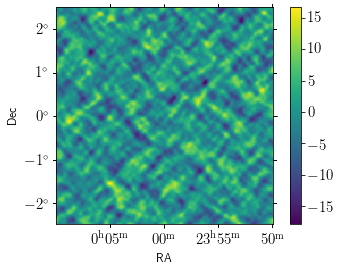

In [66]:
#Demo of randomly generated map
fmi.view_map(mpu.flatten()) 

## Generate 11,200 Maps for ML Code